In [ ]:
# Install dependencies (run only once)
!apt-get install swig
!pip install stable-baselines3[extra] gymnasium[box2d] pyglet imageio matplotlib numpy scipy


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 29 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,156 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [ ]:
# Import libraries
import numpy as np
import imageio
import os
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
# Initialize and test the environment
env = gym.make("LunarLander-v3", render_mode="human")
obs, info = env.reset()
done = False

while not done:
    action = env.action_space.sample()  # random action
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
env.close()

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

**Environment Overview** LunarLander-v3 is a Box2D physics simulation. The agent controls a lunar module and must land it between two flags. It receives rewards for successful landings, penalized for crashing, and is influenced by fuel consumption and contact with the ground.

### **Implement PPO for Lunar Lander**

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self):
        os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                mean_reward = np.mean(y[-100:])
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    self.model.save(self.save_path)
        return True


In [ ]:
#Plotting Learning Curve

def plot_results(log_folder, title='Learning Curve'):
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = np.convolve(y, np.ones(100)/100, mode='valid')
    x = x[len(x) - len(y):]
    plt.figure(figsize=(12,5))
    plt.plot(x, y)
    plt.xlabel('Timesteps')
    plt.ylabel('Reward (Smoothed)')
    plt.title(title)
    plt.grid()
    plt.show()


### **Train PPO Agent**

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92.9     |
|    ep_rew_mean     | -151     |
| time/              |          |
|    fps             | 792      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 93.9         |
|    ep_rew_mean          | -179         |
| time/                   |              |
|    fps                  | 624          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0066596596 |
|    clip_fraction        | 0.0371       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | -0.00777     

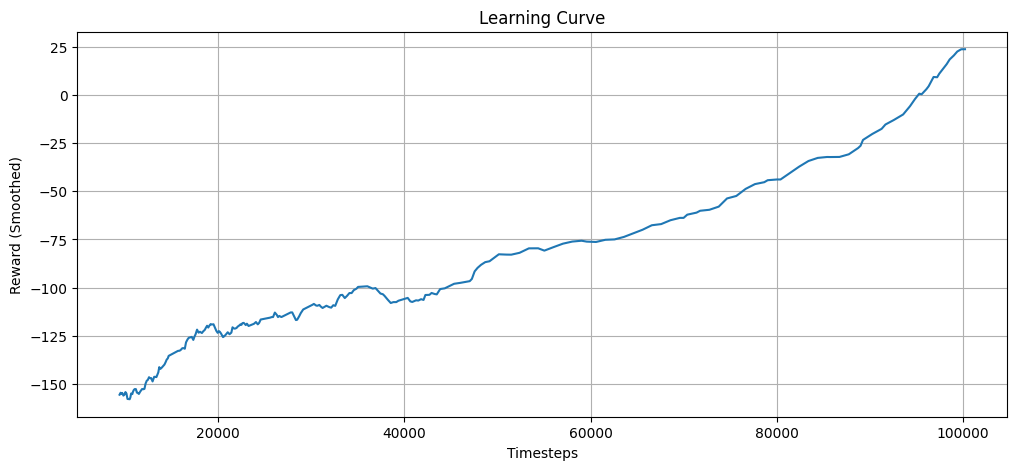

In [ ]:
log_dir = "log_dir_PPO/"
env = make_vec_env("LunarLander-v3", n_envs=1, monitor_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

model = PPO(
    policy="MlpPolicy",
    env=env,
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    verbose=1
)

model.learn(total_timesteps=100000, callback=callback)
plot_results(log_dir)


### Load and evaluate the best PPO

In [ ]:
# Load and evaluate the best PPO model
model = PPO.load(path=os.path.join(log_dir, "best_model.zip"))
eval_env = make_vec_env("LunarLander-v3", n_envs=1)
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
print(f"Mean Reward: {mean_reward}, Std Dev: {std_reward}")



Mean Reward: 63.99308979999999, Std Dev: 101.64412023728929


In [ ]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
obs, _ = env.reset()
images = []

for _ in range(350):
    img = env.render()
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break

env.close()
imageio.mimsave("lunar_lander_PPO.gif", [img for i, img in enumerate(images) if i % 2 == 0], fps=30)

<font color="gray">[Delete Me] add your writing: You can refer to our previous assignment.</font>



# IV - Results

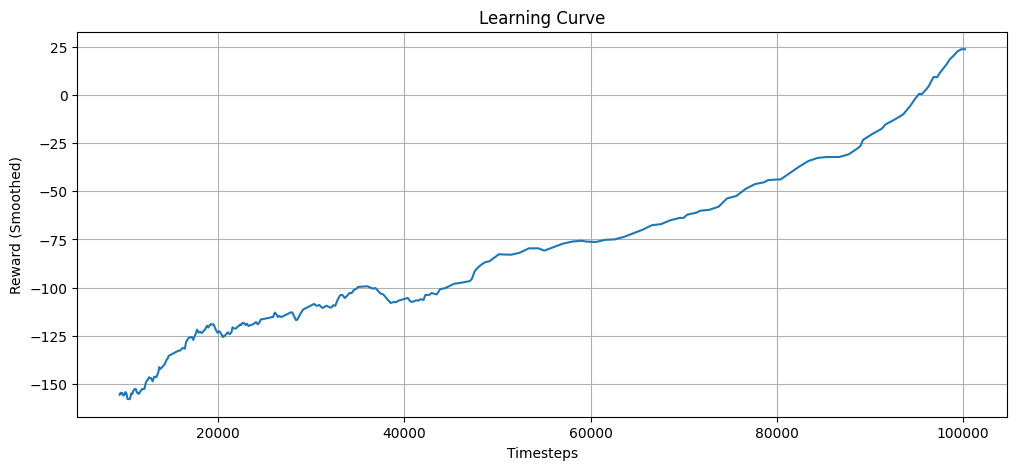

During training, the PPO agent showed steady improvement. The reward curve increased from -150 to around +25 after 100,000 timesteps, showing that the agent gradually learned how to land safely. We chose a learning rate of 0.0003 and clip range of 0.2 based on stable learning and smooth reward growth. The final policy was tested and visualized using a GIF, which confirms that the agent lands reliably between the flags. While the rewards are not yet close to the maximum (+200), the progress is clear, and further tuning (e.g., longer training, smaller clip range) could improve it even more.  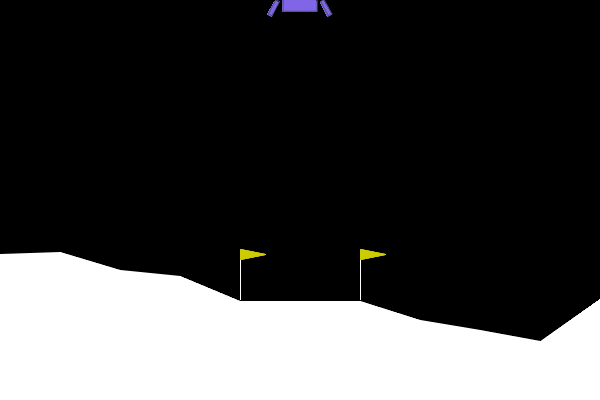